In [7]:
#20241209最新版时间序列分析
# condadl
import copy
import os

#from sklearn.decomposition import PCA
import pickle

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
from natsort import natsorted
from scipy.ndimage import distance_transform_edt, find_objects, label
from skimage import measure
from skimage.morphology import skeletonize
from sklearn.neighbors import NearestNeighbors
from tqdm import trange


def filter_small2(img, threshold):
    result = np.array(img)
    if len(result.shape) == 2:
        # 使用 SciPy 的 label 函数标记连通区域
        labeled_image, num_features = label(result)

        # 获取每个区域的边界框
        objects = find_objects(labeled_image)

        for i, obj in enumerate(objects, start=1):
            area = np.sum(labeled_image[obj] == i)
            if area < threshold:
                labeled_image[labeled_image == i] = 0
            else:
                labeled_image[labeled_image == i] = i

        result = labeled_image
    else:
        for t in range(result.shape[0]):
            labeled_image, num_features = label(result[t])
            objects = find_objects(labeled_image)
            for i, obj in enumerate(objects, start=1):
                area = np.sum(labeled_image[obj] == i)
                if area < threshold:
                    labeled_image[labeled_image == i] = 0
                else:
                    labeled_image[labeled_image == i] = i
            result[t] = labeled_image

    return result

# import logging
# #import utils

# logging.basicConfig(level=logging.INFO,
#                     format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
#                     filename='log.txt',
#                     filemode='w')


def filter_small(img,threshold):
    #统计只有0,1二值的results中连续的1值区域，过滤小杂点
    result = np.array(img)
    size_threshold = threshold

    if len(result.shape) == 2:
        # 用measure.label函数将二值图像中的连通区域进行标记
        labeled_image, num_features = measure.label(result, connectivity=2, return_num=True)

        # 使用measure.regionprops函数获取每个连通区域的属性
        region_props = measure.regionprops(labeled_image)

        i = 1
        # 遍历每个连通区域，根据面积大小进行过滤,并将符合条件的区域的像素值设为不同数字
        for props in region_props:
            if props.area < size_threshold:
                # 将面积小于阈值的区域对应的像素值设为0
                labeled_image[labeled_image == props.label] = 0
            else:
                labeled_image[labeled_image == props.label] = i
                i += 1

        result = labeled_image
    else:
        for t in trange(result.shape[0]):
            i = 1
            labeled_image, num_features = measure.label(result[t], connectivity=2, return_num=True)
            region_props = measure.regionprops(labeled_image)
            for props in region_props:
                if props.area < size_threshold:
                    labeled_image[labeled_image == props.label] = 0
                else:
                    labeled_image[labeled_image == props.label] = i
                    i += 1
            result[t] = labeled_image

    return result


def plot_multi_single_slice_analysis(root,load_exist_info = True, save_new=True):
    #need actin and data
    actin_end_sig = '_actin_result.tif'
    slice_analysis = []

    for filename in natsorted(os.listdir(root)):
        if filename.endswith(actin_end_sig):
            spine_mask_path = os.path.join(root,filename)
            dataname = filename[:-len(actin_end_sig)]+'.tif'
            actin_data_path = os.path.join(root,dataname)
            dend_mask_path = os.path.join(root,dataname[:-4]+'_dend_result.tif')
            #dend_mask_path = None
            SIMDATA1 = SIMDATA(save_path=root,actin_data_path=actin_data_path,spine_mask_path=spine_mask_path,dend_mask_path=dend_mask_path)
            this_slice_analysis = SIMDATA1.single_slice_analysis(load_exist_info=load_exist_info,save_new=save_new)
            this_slice_analysis['name'] = dataname
            this_slice_analysis['data'] = SIMDATA1.actin_data

            slice_analysis.append(this_slice_analysis)


    fig, ax = plt.subplots(max(2,len(slice_analysis)),5,figsize=(20,3*len(slice_analysis)))
    for i in range(len(slice_analysis)):
        name = slice_analysis[i]['name']
        sizes = slice_analysis[i]['sizes']
        positions = slice_analysis[i]['positions']
        intensities = slice_analysis[i]['intensities']
        types = slice_analysis[i]['types']
        filo_spine_ratio = slice_analysis[i]['filo_spine_ratio']
        distances = slice_analysis[i]['distances']
        aspect_ratios = slice_analysis[i]['aspect_ratios']
        spine_density = slice_analysis[i]['spine_density']

        ax[i,0].imshow(slice_analysis[i]['data'][0])
        ax[i,0].set_title(name)
        ax[i,0].axis('off')

        ax[i,1].hist(sizes,bins=range(0,5000,50))
        mean_size = np.mean(sizes)
        ax[i,1].set_title('Spine Size')
        ax[i,1].set_xlabel('Size: pixel')
        ax[i,1].set_ylabel('Spine Number')
        y_min,y_max = ax[i,1].get_ylim()
        ax[i,1].axvline(mean_size, color='r', linestyle='dashed', linewidth=1)
        ax[i,1].text(mean_size, 0.6*y_max, 'Mean Size: %.0f' % mean_size, rotation=0)

        ax[i,2].hist(intensities,bins=range(0,5000,50))
        mean_intensity = np.mean(intensities)
        ax[i,2].set_title('Spine Intensity')
        ax[i,2].set_xlabel('Intensity: ')
        ax[i,2].set_ylabel('Spine Number')
        y_min,y_max = ax[i,2].get_ylim()
        ax[i,2].axvline(mean_intensity, color='r', linestyle='dashed', linewidth=1)
        ax[i,2].text(mean_intensity, 0.6*y_max, 'Mean Intensity: %.0f' % mean_intensity, rotation=0)

        ax[i,3].hist(distances,bins=range(0,500,10))
        mean_distance = np.mean(distances)
        ax[i,3].set_title('Nearest Distance')
        ax[i,3].set_xlabel('Distance: pixel')
        ax[i,3].set_ylabel('Spine Number')
        y_min,y_max = ax[i,3].get_ylim()
        ax[i,3].axvline(mean_distance, color='r', linestyle='dashed', linewidth=1)
        ax[i,3].text(mean_distance, 0.6*y_max, 'Mean Distance: %.0f' % mean_distance + ' pixel', rotation=0)
        if spine_density is not None:
            ax[i,3].text(mean_distance, 0.4*y_max, 'Spine Density: %.2f' % spine_density + ' Spines / 10um dendrite', rotation=0)

        ax[i,4].hist(aspect_ratios,bins=np.arange(0,5,0.1))
        ax[i,4].set_title('Aspect Ratio')
        mean_filo_spine_ratio = np.mean(filo_spine_ratio)
        ax[i,4].set_xlabel('Aspect Ratio: ')
        ax[i,4].set_ylabel('Spine Number')
        y_min,y_max = ax[i,4].get_ylim()
        ax[i,4].axvline(2.7, color='g', linestyle='dashed', linewidth=1)
        ax[i,4].text(0, 0.6*y_max, 'Filopodia(Aspect Ratio>2.7) Ratio: %.2f' % mean_filo_spine_ratio, rotation=0)
    plt.tight_layout()
    fig.savefig(os.path.join(root,'summary.png'),bbox_inches='tight')
    plt.show()


#至少提供root和一种mask_path.
class SIMDATA:
    def __init__(self,
    save_path,#本次（批量）处理的根目录+本套数据的标识
    actin_data_path=None,spine_mask_path=None,dend_mask_path=None,presyn_data_path=None,presyn_mask_path=None,psd_data_path=None,psd_mask_path=None):
        self.actin_data_path = actin_data_path
        self.spine_mask_path = spine_mask_path
        self.dend_mask_path = dend_mask_path
        self.presyn_data_path = presyn_data_path
        self.presyn_mask_path = presyn_mask_path
        self.psd_data_path = psd_data_path
        self.psd_mask_path = psd_mask_path



        self.save_path = str(save_path)
        #依次尝试读取

        if actin_data_path is not None:
            print('loading actin data:',actin_data_path)

            if os.path.exists(actin_data_path):
                self.actin_data = tiff.imread(actin_data_path)
                if len(self.actin_data.shape) == 2:
                    self.actin_data = self.actin_data[np.newaxis,:,:]
                self.data_shape = self.actin_data.shape
            else:
                print('Warning: actin data path is not correct')


        if spine_mask_path is not None:
            print('loading spine mask:',spine_mask_path)
            if os.path.exists(spine_mask_path):
                self.spine_mask = tiff.imread(spine_mask_path)
                if len(self.spine_mask.shape) == 2:
                    self.spine_mask = self.spine_mask[np.newaxis,:,:]
                if self.actin_data_path is None:
                    self.data_shape = self.spine_mask.shape
            else:
                print('Warning: spine mask path is not correct')

        if dend_mask_path is not None:
            if os.path.exists(dend_mask_path):
                print('loading dend mask:',dend_mask_path)
                self.dend_mask = tiff.imread(dend_mask_path)
                if len(self.dend_mask.shape) == 2:
                    self.dend_mask = self.dend_mask[np.newaxis,:,:]
                self.have_dend_mask = True
            else:
                print('Warning: dend mask path is not correct')

        if presyn_data_path is not None:
            if os.path.exists(presyn_data_path):
                print('loading presyn data:',presyn_data_path)
                self.presyn_data = tiff.imread(presyn_data_path)
                if len(self.presyn_data.shape) == 2:
                    self.presyn_data = self.presyn_data[np.newaxis,:,:]
                self.have_presyn_data = True
            else:
                print('Warning: presyn data path is not correct')
        if presyn_mask_path is not None:
            if os.path.exists(presyn_mask_path):
                print('loading presyn mask:',presyn_mask_path)
                self.presyn_mask = tiff.imread(presyn_mask_path)
                if len(self.presyn_mask.shape) == 2:
                    self.presyn_mask = self.presyn_mask[np.newaxis,:,:]
                self.have_presyn_mask = True
            else:
                print('Warning: presyn mask path is not correct')
        if psd_data_path is not None:
            if os.path.exists(psd_data_path):
                print('loading psd data:',psd_data_path)
                self.psd_data = tiff.imread(psd_data_path)
                if len(self.psd_data.shape) == 2:
                    self.psd_data = self.psd_data[np.newaxis,:,:]
                self.have_psd_data = True
            else:
                print('Warning: psd data path is not correct')
        if psd_mask_path is not None:
            if os.path.exists(psd_mask_path):
                print('loading psd mask:',psd_mask_path)
                self.psd_mask = tiff.imread(psd_mask_path)
                if len(self.psd_mask.shape) == 2:
                    self.psd_mask = self.psd_mask[np.newaxis,:,:]
                self.have_psd_mask = True
            else:
                print('Warning: psd mask path is not correct')


    def get_attr_by_name(self,attr):
        if hasattr(self,attr):
            return getattr(self,attr)
        else:
            return None

    def calculate_aspect_ratio(self,binary_mask):
        #binary_mask = (mask_slice == spine_id).astype(np.uint8)
        binary_mask = binary_mask.astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        points = contours[0]

        rect = cv2.minAreaRect(points)
        # box = cv2.boxPoints(rect)
        # box = np.int0(box)
        width = rect[1][0]
        height = rect[1][1]
        if width < height:
            length = height
            width = width
        else:
            length = width
            width = height
        if width == 0:
            aspect_ratio = 1
        else:
            aspect_ratio = length / width
        return length, width, aspect_ratio

    def find_dend_touch_point(self,position,dend_mask_skeleton_slice,radius=100):
        position = [int(i) for i in position]
        test_search_area = np.zeros([radius*2,radius*2])
        test_search_area[radius,radius] = 1
        radius_distance_map = distance_transform_edt(1-test_search_area)
        dend_nearby_area = np.zeros([radius*2,radius*2])
        dend_nearby_area[radius-min(radius, position[0]):radius+min(radius,dend_mask_skeleton_slice.shape[0]- position[0]),radius-min(radius, position[1]):radius+min(radius,dend_mask_skeleton_slice.shape[1]- position[1])] = dend_mask_skeleton_slice[max(0, position[0]-radius):min(dend_mask_skeleton_slice.shape[0], position[0]+radius),max(0, position[1]-radius):min(dend_mask_skeleton_slice.shape[1], position[1]+radius)]
        multiplied_area = np.multiply(dend_nearby_area,radius_distance_map)
        if np.max(multiplied_area) == 0:
            #nozero_min_value = 0
            nearest_den_point = None
        else:
            nozero_min_value = np.min(multiplied_area[multiplied_area>0])
            nozero_min_index = np.argwhere(multiplied_area == nozero_min_value)[0]
            # = np.argmin(np.multiply(dend_nearby_area,radius_distance_map))
            nearest_den_point = [nozero_min_index[0] +  position[0]-radius,nozero_min_index[1] +  position[1]-radius]
        return nearest_den_point


    def spigle_spine_info_cal(self,spine_id,mask_type='spine'):
        pass

    def single_slice_info_cal(self,slice_id,mask_type='spine',needed_props_list = [], load_exist_info=True,save_new=False):
        #print('calculating slice:',slice_id)
        slice_info_save_path = os.path.join(self.save_path,'slice_infos', mask_type, (self.get_attr_by_name(mask_type+'_mask_path')).split('/')[-1][:-4]+f'_slice_{slice_id}_info.pkl')
        if load_exist_info and os.path.exists(slice_info_save_path):
            with open(slice_info_save_path, 'rb') as f:
                print('loading slice info:',slice_info_save_path)
                slice_info = pickle.load(f)
                #return slice_info

        else:
            #print('calculating slice:',slice_id)
            print('needed_props_list:',needed_props_list)
            slice_info = dict()

            mask_slice = self.get_attr_by_name(mask_type+'_mask')[slice_id]
            if hasattr(self,'actin_data'):
                actin_data_slice = self.actin_data[slice_id]
            if hasattr(self,'psd_mask'):
                psd_mask_slice = self.psd_mask[slice_id]
                psd_mask_slice = filter_small2(psd_mask_slice,threshold=20)
            if hasattr(self,'presyn_mask'):
                presyn_mask_slice = self.presyn_mask[slice_id]
                #presyn_mask_slice = filter_small(presyn_mask_slice,threshold=20)
            if hasattr(self,'dend_mask'):
                dend_mask_slice = self.dend_mask[slice_id]
                #dend_mask_slice = filter_small(dend_mask_slice,threshold=80)
                dend_mask_binary_slice = dend_mask_slice > 0
                dend_mask_skeleton_slice = skeletonize(dend_mask_binary_slice)
                # dend_distance_map = distance_transform_edt(dend_mask_binary)
                # dend_skeleton_with_radius = np.multiply(dend_mask_skeleton_slice,dend_distance_map)

                dend_length = np.sum(dend_mask_skeleton_slice)





            spine_ids = np.unique(mask_slice)
            spine_ids = spine_ids[spine_ids != 0]

            for spine_id in spine_ids:
                spine_info = dict()

                #mask
                spine_in_mask =   mask_slice == spine_id
                spine_info['size'] = np.count_nonzero(spine_in_mask)
                spine_info['position'] = np.nanmean(np.where(spine_in_mask),axis=1)


                length, width, aspect_ratio = self.calculate_aspect_ratio(spine_in_mask)
                spine_info['length'] = length
                spine_info['width'] = width
                spine_info['aspect_ratio'] = aspect_ratio

                if aspect_ratio > 2.6:
                    spine_info['type'] = 'filopodia'
                else:
                    spine_info['type'] = 'spine'

                #actin_data
                if hasattr(self,'actin_data'):
                    spine_info['intensity'] = np.nanmean(actin_data_slice[spine_in_mask])
                else:
                    spine_info['intensity'] = None

                #psd_mask
                if hasattr(self,'psd_mask'):
                    _multi = np.multiply(mask_slice == spine_id , psd_mask_slice)
                    spine_info['puncta_num'] = np.count_nonzero(np.unique(_multi))
                    spine_info['puncta_size'] = np.count_nonzero(_multi)
                else:
                    spine_info['puncta_num'] = None
                    spine_info['puncta_size'] = None

                #dend_mask
                if hasattr(self,'dend_mask'):
                    spine_info['dend_overlap'] = np.count_nonzero(np.multiply(mask_slice == spine_id , dend_mask_slice))
                    spine_info['dend_length'] = dend_length
                else:
                    spine_info['dend_overlap'] = None
                    spine_info['dend_length'] = None

                #presyn_mask
                if hasattr(self,'presyn_mask'):
                    spine_info['presyn_size'] = np.count_nonzero(np.multiply(mask_slice == spine_id , presyn_mask_slice))
                else:
                    spine_info['presyn_size'] = None






                slice_info[spine_id] = spine_info

        #如果slice_info没有‘distance'key就计算
        #distance需要所有点的信息所以额外放这里
        if 'distance' not in next(iter(slice_info.values())).keys():
            if 'distance' in needed_props_list or 'all' in needed_props_list:
                mask_slice = self.get_attr_by_name(mask_type+'_mask')[slice_id]
                spine_ids = np.unique(mask_slice)
                spine_ids = spine_ids[spine_ids != 0]
                positions = [slice_info[spine_id]['position'] for spine_id in spine_ids]
                positions = np.array(positions)
                nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(positions)
                distances, indices = nbrs.kneighbors(positions)
                distances = distances[:,1]
                for i,spine_id in enumerate(spine_ids):
                    slice_info[spine_id]['distance'] = distances[i]
            else:
                for spine_id in spine_ids:
                    slice_info[spine_id]['distance'] = None

        if 'dend_touch_point' not in next(iter(slice_info.values())).keys() and hasattr(self,'dend_mask'):
            if 'dend_touch_point' in needed_props_list or 'all' in needed_props_list:
                mask_slice = self.get_attr_by_name(mask_type+'_mask')[slice_id]
                spine_ids = np.unique(mask_slice)
                spine_ids = spine_ids[spine_ids != 0]
                positions = [slice_info[spine_id]['position'] for spine_id in spine_ids]
                positions = np.array(positions)

                # with concurrent.futures.ThreadPoolExecutor() as executor:
                #     futures = []
                for i,spine_id in enumerate(spine_ids):
                    position = slice_info[spine_id]['position']
                    nearest_den_point = self.find_dend_touch_point(position,dend_mask_skeleton_slice,radius=100)
                    slice_info[spine_id]['dend_touch_point'] = nearest_den_point
            else:
                for spine_id in spine_ids:
                    slice_info[spine_id]['dend_touch_point'] = None






        if save_new:
            if not os.path.exists(os.path.dirname(slice_info_save_path)):
                os.makedirs(os.path.dirname(slice_info_save_path))
            with open(slice_info_save_path, 'wb') as f:
                pickle.dump(slice_info, f)

            # mask_slice1 = np.zeros_like(mask_slice)

            # for spine_id in spine_ids:
            #     mask_slice1[mask_slice == spine_id] = 1 if slice_info[spine_id]['type'] == 'spine' else 2
            # tiff.imwrite(os.path.join(self.rootpath, self.name.split('.')[-2]+ f'_slice_{slice_id}_type.tif'), mask_slice1)
        return slice_info

    def single_slice_analysis(self,slice_id=0,mask_type='spine',load_exist_info = True, save_new=False):
        #待更新
        slice_info = self.single_slice_info_cal(slice_id,mask_type,load_exist_info,save_new)
        spine_ids = list(slice_info.keys())
        sizes = [slice_info[spine_id]['size'] for spine_id in spine_ids]
        sizes = np.array(sizes)
        positions = [slice_info[spine_id]['position'] for spine_id in spine_ids]
        positions = np.array(positions)
        intensities = [slice_info[spine_id]['intensity'] for spine_id in spine_ids]
        puncta_nums = [slice_info[spine_id]['puncta_num'] for spine_id in spine_ids]
        puncta_sizes = [slice_info[spine_id]['puncta_size'] for spine_id in spine_ids]

        aspect_ratios = [slice_info[spine_id]['aspect_ratio'] for spine_id in spine_ids]
        types = [slice_info[spine_id]['type'] for spine_id in spine_ids]
        filo_spine_ratio = types.count('filopodia') / len(types)

        # nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(positions)
        # distances, indices = nbrs.kneighbors(positions)
        # distances = distances[:,1]
        distances = [slice_info[spine_id]['distance'] for spine_id in spine_ids]

        dend_touch_points = [slice_info[spine_id]['dend_touch_point'] for spine_id in spine_ids]

        spine_num = sum(1 for point in dend_touch_points if point is not None ) #len(spine_ids)
        dend_length_pixel = slice_info[spine_ids[0]]['dend_length']
        if dend_length_pixel is not None:
            #print(dend_length_pixel)
            pixel_size =  32.6797 #nm 这个好像其实不应该写在这里

            spine_density = spine_num / (dend_length_pixel * pixel_size / 10000) #spines / 10um
        else:
            spine_density = None

        return dict(sizes=sizes,positions=positions,intensities=intensities,puncta_nums=puncta_nums,puncta_sizes=puncta_sizes,aspect_ratios=aspect_ratios,types=types,filo_spine_ratio=filo_spine_ratio,distances=distances,spine_density=spine_density)

    def slices_infos_cal(self,mask_type='spine',needed_props_list = [], load_exist_info = True, save_new=True):
        #print('calculating slices infos')
        #slices_infos_save_path = os.path.join(self.save_path,'slices_infos', mask_type+'_slices_infos.pkl')
        slices_infos_save_path = os.path.join(self.save_path,'slices_infos', mask_type, (self.get_attr_by_name(mask_type+'_mask_path')).split('/')[-1][:-4]+'_slices_infos.pkl')

        if load_exist_info and os.path.exists(slices_infos_save_path):
            with open(slices_infos_save_path,'rb') as f:
                print('loading slices infos:',slices_infos_save_path)
                slices_infos = pickle.load(f)

        else:
            print('calculating slices infos')
            slices_infos = []
            for i in trange(self.data_shape[0]):
                slice_info = self.single_slice_info_cal(i,mask_type,needed_props_list, load_exist_info,save_new)
                slices_infos.append(slice_info)

        if save_new:
            #如果slice_infos_save_path的目录不存在，就创建

            if not os.path.exists(os.path.dirname(slices_infos_save_path)):
                os.makedirs(os.path.dirname(slices_infos_save_path))
            with open(slices_infos_save_path, 'wb') as f:
                pickle.dump(slices_infos, f)
        return slices_infos #list of dict

    def spines_infos_cal(self,mask_type='spine',needed_props_list = [], load_exist_info = True, save_new=True):


        # spines_infos_save_path = os.path.join(self.save_path,'spines_infos', mask_type+'_spines_infos.pkl')
        # ID2spines_infos_list_index_dict_save_path = os.path.join(self.save_path,'spines_infos', mask_type+'_ID2spines_infos_list_index_dict.pkl')
        spines_infos_save_path = os.path.join(self.save_path,'spines_infos', mask_type, (self.get_attr_by_name(mask_type+'_mask_path')).split('/')[-1][:-4]+'_spines_infos.pkl')
        ID2spines_infos_list_index_dict_save_path = os.path.join(self.save_path,'spines_infos', mask_type, (self.get_attr_by_name(mask_type+'_mask_path')).split('/')[-1][:-4]+'_ID2spines_infos_list_index_dict.pkl')

        if load_exist_info and os.path.exists(spines_infos_save_path):
            with open(spines_infos_save_path, 'rb') as f:
                print('loading spines infos:',spines_infos_save_path)
                spines_infos_list = pickle.load(f)
            with open(ID2spines_infos_list_index_dict_save_path, 'rb') as f:
                ID2spines_infos_list_index_dict = pickle.load(f)
                # spine_ids = np.unique(self.get_attr_by_name(mask_type+'_mask'))
                # #不包含0
                # spine_ids = spine_ids[spine_ids != 0]
                # ID2spines_infos_list_index_dict = dict()
                # for i,spine_id in enumerate(spine_ids):
                #     ID2spines_infos_list_index_dict[spine_id] = i
        else:
            #spine_info_keys = list(slices_infos[0][0].keys()) ????
            slices_infos = self.slices_infos_cal(mask_type,needed_props_list=needed_props_list, load_exist_info=load_exist_info,save_new=save_new)
            print(len(slices_infos))
            print('calculating spines infos')
            spines_infos_list = []
            #spine_infos[0]的spin_id是1
            spine_ids = np.unique(self.get_attr_by_name(mask_type+'_mask'))
            #不包含0
            spine_ids = spine_ids[spine_ids != 0]
            #spine_num = len(np.unique(self.get_attr_by_name(mask_type+'_mask')))
            #!!!待修改。reid？ #是不是已经改过了
            spine_info_keys = next(iter(slices_infos[0].values())).keys()
            empty_spine_info_dict = dict()
            empty_spine_info_dict['ID'] = None
            empty_spine_info_dict['t'] = []
            for key in spine_info_keys:
                empty_spine_info_dict[key] = []
            ID2spines_infos_list_index_dict = dict()
            for i,spine_id in enumerate(spine_ids):
                ID2spines_infos_list_index_dict[spine_id] = i
            #spine_num = max(np.unique(self.get_attr_by_name(mask_type+'_mask')))
            for spine_id in spine_ids:
                spine_info_dict = copy.deepcopy(empty_spine_info_dict)
                #spine_info_dict = empty_spine_info_dict.copy.deepcopy()
                spine_info_dict['ID'] = spine_id
                spines_infos_list.append(spine_info_dict)

            # print('spine_1',spines_infos_list[1])
            for t in trange(self.get_attr_by_name(mask_type+'_mask').shape[0]):
                # print('t:',t)
                slice_info_dict = slices_infos[t]
                spine_id_in_slice = list(slice_info_dict.keys())
                for spine_id in spine_id_in_slice:
                    # if spine_id != 2:
                    #     continue
                    this_slice_spine_info = slice_info_dict[spine_id]
                    spines_infos_list[ID2spines_infos_list_index_dict[spine_id]]['t'].append(t)
                    # print('spine_id:',spine_id)
                    # print('t',t)
                    for key in this_slice_spine_info.keys():
                        spines_infos_list[ID2spines_infos_list_index_dict[spine_id]][key].append(this_slice_spine_info[key])
                #         print(key,':',this_slice_spine_info[key])
                # if t == 2:
                #     break
            # print('spine_1',spines_infos_list[1])
            # print("enmty_spine_info_dict",empty_spine_info_dict)

                # spine_ids = list(slice_info.keys())
                # for spine_id in spine_ids:
                #     print(spine_id)
                #     spine_info = spines_infos_list[spine_id-1]
                #     if spine_id in slice_info:
                #         spine_info['t'].append(t)
                #         spine_info['size'].append(slice_info[spine_id]['size'])
                #         spine_info['position'].append(slice_info[spine_id]['position'])
                #         spine_info['intensity'].append(slice_info[spine_id]['intensity'])
                #         spine_info['puncta_num'].append(slice_info[spine_id]['puncta_num'])
                #         spine_info['puncta_size'].append(slice_info[spine_id]['puncta_size'])
                #         spine_info['dend_overlap'].append(slice_info[spine_id]['dend_overlap'])
                #         spine_info['presyn_size'].append(slice_info[spine_id]['presyn_size'])
                #         spine_info['length'].append(slice_info[spine_id]['length'])
                #         spine_info['width'].append(slice_info[spine_id]['width'])
                #         spine_info['aspect_ratio'].append(slice_info[spine_id]['aspect_ratio'])
                #         spine_info['type'].append(slice_info[spine_id]['type'])
                #         spine_info['distance'].append(slice_info[spine_id]['distance'])
                #         spines_infos_list[spine_id-1] = spine_info

        if save_new:
            if not os.path.exists(os.path.dirname(spines_infos_save_path)):
                os.makedirs(os.path.dirname(spines_infos_save_path))
            with open(spines_infos_save_path, 'wb') as f:
                pickle.dump(spines_infos_list, f)
            with open(ID2spines_infos_list_index_dict_save_path, 'wb') as f:
                pickle.dump(ID2spines_infos_list_index_dict, f)


        return spines_infos_list,ID2spines_infos_list_index_dict


    def time_series_info_cal(self,mask_type='spine',load_exist_info = True, save_new=False):
        time_series_info_save_path = os.path.join(self.save_path,'time_series_infos', mask_type+'_time_series_infos.pkl')
        if load_exist_info and os.path.exists(time_series_info_save_path):
            with open(time_series_info_save_path, 'rb') as f:
                print('loading time series info:',time_series_info_save_path)
                time_series_info = pickle.load(f)

        else:
            print('calculating time series info')
            slices_infos = self.slices_infos_cal(mask_type,load_exist_info,save_new)
            avg_sizes = []
            avg_intensities = []
            avg_puncta_nums = []
            avg_puncta_sizes = []
            avg_dend_overlaps = []
            avg_presyn_sizes = []
            avg_filo_spine_ratios = []
            avg_distances = []
            for slice_info in slices_infos:
                spine_ids = list(slice_info.keys())
                sizes = [slice_info[spine_id]['size'] for spine_id in spine_ids]
                avg_sizes.append(np.mean(sizes))
                intensities = [slice_info[spine_id]['intensity'] for spine_id in spine_ids]
                avg_intensities.append(np.mean(intensities))
                puncta_nums = [slice_info[spine_id]['puncta_num'] for spine_id in spine_ids]
                avg_puncta_nums.append(np.mean(puncta_nums))
                puncta_sizes = [slice_info[spine_id]['puncta_size'] for spine_id in spine_ids]
                avg_puncta_sizes.append(np.mean(puncta_sizes))
                dend_overlaps = [slice_info[spine_id]['dend_overlap'] for spine_id in spine_ids]
                avg_dend_overlaps.append(np.mean(dend_overlaps))
                presyn_sizes = [slice_info[spine_id]['presyn_size'] for spine_id in spine_ids]
                avg_presyn_sizes.append(np.mean(presyn_sizes))
                filo_spine_ratios = [slice_info[spine_id]['type'] for spine_id in spine_ids]
                avg_filo_spine_ratios.append(filo_spine_ratios.count('filopodia') / len(filo_spine_ratios))
                distances = [slice_info[spine_id]['distance'] for spine_id in spine_ids]
                avg_distances.append(np.mean(distances))
            time_series_info = dict(avg_sizes=avg_sizes,avg_intensities=avg_intensities,avg_puncta_nums=avg_puncta_nums,avg_puncta_sizes=avg_puncta_sizes,avg_dend_overlaps=avg_dend_overlaps,avg_presyn_sizes=avg_presyn_sizes,avg_filo_spine_ratios=avg_filo_spine_ratios,avg_distances=avg_distances)

        if save_new:
            if not os.path.exists(os.path.dirname(time_series_info_save_path)):
                os.makedirs(os.path.dirname(time_series_info_save_path))
            with open(time_series_info_save_path, 'wb') as f:
                pickle.dump(time_series_info, f)
            fig, ax = plt.subplots(7,1,figsize=(10,20))
            ax[0].plot(avg_sizes)
            ax[0].set_title('Spine Size')
            ax[1].plot(avg_intensities)
            ax[1].set_title('Spine Intensity')
            ax[2].plot(avg_puncta_nums)
            ax[2].set_title('Puncta Number')
            ax[3].plot(avg_puncta_sizes)
            ax[3].set_title('Puncta Size')
            ax[4].plot(avg_dend_overlaps)
            ax[4].set_title('Dendritic Overlap')
            ax[5].plot(avg_presyn_sizes)
            ax[5].set_title('Presynaptic Size')
            ax[6].plot(avg_filo_spine_ratios)
            ax[6].set_title('Filopodia Ratio')
            plt.tight_layout()
            fig.savefig(os.path.join(self.save_path,self.save_path.split('/')[-1]+'-time_series_summary.png'),bbox_inches='tight')



#if __name__ == '__main__':
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--name', type=str, default='test')
    # args = parser.parse_args()
    # name = args.name
    # save_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/analysis/time-series_sbatch',name)
    # actin_data_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/actin',name+'-actin.tif')
    # spine_mask_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/actin/0result-train12-weights2-unet_180-th_05-ft_80-spine',name+'-actin_spine_result_track.tif')
    # dend_mask_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/actin/0result-traindata-weights3-unet_150-th_01-ft_500-dend',name+'-actin_dend_result.tif')
    # presyn_data_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/presyn',name+'-presyn.tif')
    # presyn_mask_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/presyn/0result-train12-weights2-unet_180-th_05-ft_80-presyn',name+'-presyn_presyn_result.tif')
    # psd_data_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/psd',name+'-psd.tif')
    # psd_mask_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/psd',name+'-psd_psd_result.tif')
    # #为什么光是读完就要 36min？/5min
    # SIMDATA1 = SIMDATA(save_path=save_path,actin_data_path=actin_data_path,spine_mask_path=spine_mask_path,dend_mask_path=dend_mask_path,presyn_data_path=presyn_data_path,presyn_mask_path=presyn_mask_path,psd_data_path=psd_data_path,psd_mask_path=psd_mask_path)
    # #SIMDATA1.spines_infos_cal(mask_type='spine',load_exist_info = True ,save_new=True)
    # SIMDATA1.time_series_info_cal(mask_type='spine',load_exist_info = True ,save_new=True)

    # for filename in os.listdir('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/actin'):
    #     if filename.endswith('-actin.tif'):
    #         name = filename.split('-')[0]
    #         save_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/analysis/time-series_sbatch',name)
    #         actin_data_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/actin',name+'-actin.tif')
    #         spine_mask_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/actin/0result-train12-weights2-unet_180-th_05-ft_80-spine',name+'-actin_spine_result_track.tif')
    #         dend_mask_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/actin/0result-traindata-weights3-unet_150-th_01-ft_500-dend',name+'-actin_dend_result.tif')
    #         presyn_data_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/presyn',name+'-presyn.tif')
    #         presyn_mask_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/presyn/0result-train12-weights2-unet_180-th_05-ft_80-presyn',name+'-presyn_presyn_result.tif')
    #         psd_data_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/psd',name+'-psd.tif')
    #         psd_mask_path = os.path.join('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/psd',name+'-psd_psd_result.tif')
    #         #为什么光是读完就要 36min？/5min
    #         SIMDATA1 = SIMDATA(save_path=save_path,actin_data_path=actin_data_path,spine_mask_path=spine_mask_path,dend_mask_path=dend_mask_path,presyn_data_path=presyn_data_path,presyn_mask_path=presyn_mask_path,psd_data_path=psd_data_path,psd_mask_path=psd_mask_path)
    #         SIMDATA1.spines_infos_cal(mask_type='spine',save=True)


    #plot_multi_single_slice_analysis('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/analysis/test/dend_length_test')
    #plot_multi_single_slice_analysis('/share/data/CryoET_Data/lizhuo/SIM-process/240924/data/analysis/single-slice-comparision/hwl',False,True)

In [90]:
actin_data_path = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007.tif'
spine_mask_path = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007_label.tif'
presyn_data_path = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq3_3D-SIM561_RedCh_SIrecon-0007.tif'
presyn_mask_path = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq3_3D-SIM561_RedCh_SIrecon_presyn_result-0007.tif'
psd_data_path = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq1_3D-SIM640_RedCh_SIrecon-0007.tif'
psd_mask_path = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq1_3D-SIM640_RedCh_SIrecon-0007_psd_mask.tif'
root = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test'
SIM2 = SIMDATA(save_path=root,actin_data_path=actin_data_path,spine_mask_path=spine_mask_path,presyn_data_path=presyn_data_path,presyn_mask_path=presyn_mask_path,psd_data_path=psd_data_path,psd_mask_path=psd_mask_path)

loading actin data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007.tif
loading spine mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007_label.tif
loading presyn data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq3_3D-SIM561_RedCh_SIrecon-0007.tif
loading presyn mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq3_3D-SIM561_RedCh_SIrecon_presyn_result-0007.tif
loading psd data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq1_3D-SIM640_RedCh_SIrecon-0007.tif
loading psd mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/Stablized AVG_roi3_seq1_3D-SIM640_RedCh_SIrecon-0007_psd_mask.tif


In [91]:
needed_props_list = ['all','size','position','intensity','puncta_num','puncta_size']
#needed_props_list = ['size']
spine_infos, ID2spines_infos_list_index_dict  = SIM2.spines_infos_cal(mask_type='spine',needed_props_list = needed_props_list, load_exist_info = True, save_new=True)

calculating slices infos


100%|██████████| 80/80 [00:00<00:00, 600.61it/s]

loading slice info: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/slice_infos/spine/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007_label_slice_0_info.pkl
loading slice info: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/slice_infos/spine/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007_label_slice_1_info.pkl
loading slice info: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/slice_infos/spine/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007_label_slice_2_info.pkl
loading slice info: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/slice_infos/spine/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007_label_slice_3_info.pkl
loading slice info: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/slice_infos/spine/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007_label_slice_4_info.pkl
loading slice info: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/slic


100%|██████████| 80/80 [00:00<00:00, 27703.46it/s]


In [16]:
next(iter([1]))

1

In [88]:
ID2spines_infos_list_index_dict

{1: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5}

In [87]:

SIM_3_7 = SIMDATA(save_path=root)
spine_infos, ID2spines_infos_list_index_dict  = SIM_3_7.spines_infos_cal(mask_type='spine',needed_props_list = needed_props_list, load_exist_info = True, save_new=False)
#spine_infos[0]['ID']

loading spines infos: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch-test/spines_infos/spine_spines_infos.pkl


In [21]:
filename = 'Stablized AVG_roi3_seq3_3D-SIM561_RedCh_SIrecon_presyn_result-0007.tif'
patch_id = filename[-8:-4]
presyn_mask_signal = '_presyn_result'
presyn_data_name_pre = filename.split(presyn_mask_signal)[0]
presyn_data_name_pre

'Stablized AVG_roi3_seq3_3D-SIM561_RedCh_SIrecon'

In [8]:
#文件夹处理
#要求：只能有一套数据，但可以有多个patch（各patch除了patch_id以外完全相同）
#文件名应符合 name_pre + '-' + patch id (+signal).tif #presyn可以先patch再分割，也可以先分割再patch
#dir_path = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch'
#needed_props_list = ['all']

def merge_spine_infos(spine_infos_dict_dict):
    merged_spine_infos = list()
    merged_ID_or_index_2_patch_ID_dict = dict()
    new_id = 0
    for key in spine_infos_dict_dict.keys():
        spine_infos = spine_infos_dict_dict[key]
        for spine_info in spine_infos:
            # print('key',key)
            # print(spine_info['ID'])
            merged_ID_or_index_2_patch_ID_dict[new_id] = str(key)+'_'+str(spine_info['ID'])
            spine_info['ID'] = new_id
            merged_spine_infos.append(spine_info)
            new_id += 1

    return merged_spine_infos,merged_ID_or_index_2_patch_ID_dict

def patches_spine_info_cal(dir_path,needed_props_list=['all']):
    spine_mask_signal_list = ['_label']
    presyn_mask_signal_list = ['_presyn_result']
    psd_mask_signal_list = ['_psd_mask']
    dend_mask_signal_list = ['_dend_result']

    SIM_dict = dict()
    spine_infos_dict = dict()
    ID2spines_infos_list_index_dict_dict = dict()
    presyn_patched_after_seg_dict = dict()
    patch_id_list = []
    actin_data_name_pre = ''
    presyn_data_name_pre = ''
    psd_data_name_pre = ''

    for filename in os.listdir(dir_path):
        if filename.endswith('.tif'):
            for spine_mask_signal in spine_mask_signal_list:
                if spine_mask_signal in filename:
                    patch_id = filename.split(spine_mask_signal)[0].split('-')[-1]
                    actin_data_name_pre = filename.split(patch_id)[0]
                    patch_id_list.append(patch_id)
                    break
            for presyn_mask_signal in presyn_mask_signal_list:
                if presyn_mask_signal in filename:

                    if filename.endswith(presyn_mask_signal+'.tif'): #先patch再分割
                        #print(filename)
                        patch_id = filename.split(presyn_mask_signal)[0].split('-')[-1]
                        presyn_data_name_pre = filename.split(patch_id)[0]
                        patch_id_list.append(patch_id)
                        presyn_patched_after_seg_dict[patch_id] = False
                        break
                    else: # 先分割再patch
                        patch_id = filename[-8:-4]
                        presyn_data_name_pre = filename.split(presyn_mask_signal)[0]
                        patch_id_list.append(patch_id)
                        presyn_patched_after_seg_dict[patch_id] = True
                        break
            for psd_mask_signal in psd_mask_signal_list:
                if psd_mask_signal in filename:
                    patch_id = filename.split(psd_mask_signal)[0].split('-')[-1]
                    psd_data_name_pre = filename.split(patch_id)[0]
                    patch_id_list.append(patch_id)
                    break
            for dend_mask_signal in dend_mask_signal_list:
                if dend_mask_signal in filename:
                    patch_id = filename.split(dend_mask_signal)[0].split('-')[-1]
                    actin_data_name_pre = filename.split(patch_id)[0]
                    patch_id_list.append(patch_id)
                    break

    for patch_id in list(set(patch_id_list)):
        # if patch_id == '0008':
        #     continue
        actin_data_path = os.path.join(dir_path,actin_data_name_pre + patch_id + '.tif')
        spine_mask_path = os.path.join(dir_path,actin_data_name_pre + patch_id + spine_mask_signal + '.tif')
        dend_mask_path = os.path.join(dir_path,actin_data_name_pre + patch_id + dend_mask_signal + '.tif')

        if presyn_patched_after_seg_dict[patch_id]:
            presyn_data_path = os.path.join(dir_path,presyn_data_name_pre + '-' + patch_id + '.tif')
            presyn_mask_path = os.path.join(dir_path,presyn_data_name_pre + presyn_mask_signal + '-' + patch_id + '.tif')
        else:
            presyn_data_path = os.path.join(dir_path,presyn_data_name_pre + patch_id + '.tif')
            presyn_mask_path = os.path.join(dir_path,presyn_data_name_pre + patch_id + presyn_mask_signal + '.tif')
        psd_data_path = os.path.join(dir_path,psd_data_name_pre + patch_id + '.tif')
        psd_mask_path = os.path.join(dir_path,psd_data_name_pre + patch_id + psd_mask_signal + '.tif')

        root = os.path.join(dir_path)
        SIM = SIMDATA(save_path=root,actin_data_path=actin_data_path,spine_mask_path=spine_mask_path,dend_mask_path=dend_mask_path,presyn_data_path=presyn_data_path,presyn_mask_path=presyn_mask_path,psd_data_path=psd_data_path,psd_mask_path=psd_mask_path)
        SIM_dict[patch_id] = SIM
        spine_infos, ID2spines_infos_list_index_dict  = SIM.spines_infos_cal(mask_type='spine',needed_props_list = needed_props_list, load_exist_info = False, save_new=True)
        spine_infos_dict[patch_id] = spine_infos
        ID2spines_infos_list_index_dict_dict[patch_id] = ID2spines_infos_list_index_dict

    merged_spine_infos,merged_ID_or_index_2_patch_ID_dict = merge_spine_infos(spine_infos_dict)
    return merged_spine_infos,merged_ID_or_index_2_patch_ID_dict



In [9]:
roi1_dir_path = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch'
roi1_spine_infos_merged,roi1_ID_or_index_2_patch_ID_dict = patches_spine_info_cal(roi1_dir_path,needed_props_list=['all'])

loading actin data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq3_3D-SIM561_RedCh_SIrecon-0008.tif
loading spine mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq3_3D-SIM561_RedCh_SIrecon-0008_label.tif
loading presyn data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq2_3D-SIM488_GreenCh_SIrecon-0008.tif
loading presyn mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq2_3D-SIM488_GreenCh_SIrecon-0008_presyn_result.tif
loading psd data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq1_3D-SIM640_RedCh_SIrecon-0008.tif
loading psd mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq1_3D-SIM640_RedCh_SIrecon-0008_psd_mask.tif
calculating slices infos


  0%|          | 0/80 [00:00<?, ?it/s]

needed_props_list: ['all']


  1%|▏         | 1/80 [00:01<02:31,  1.91s/it]

needed_props_list: ['all']


  2%|▎         | 2/80 [00:02<01:20,  1.03s/it]

needed_props_list: ['all']


  4%|▍         | 3/80 [00:02<00:58,  1.32it/s]

needed_props_list: ['all']


  5%|▌         | 4/80 [00:03<00:50,  1.49it/s]

needed_props_list: ['all']


  6%|▋         | 5/80 [00:03<00:41,  1.82it/s]

needed_props_list: ['all']


  8%|▊         | 6/80 [00:04<00:42,  1.72it/s]

needed_props_list: ['all']


  9%|▉         | 7/80 [00:04<00:43,  1.66it/s]

needed_props_list: ['all']


 10%|█         | 8/80 [00:06<01:05,  1.11it/s]

needed_props_list: ['all']


 11%|█▏        | 9/80 [00:07<01:01,  1.16it/s]

needed_props_list: ['all']


 12%|█▎        | 10/80 [00:07<00:54,  1.27it/s]

needed_props_list: ['all']


 14%|█▍        | 11/80 [00:08<00:53,  1.30it/s]

needed_props_list: ['all']


 15%|█▌        | 12/80 [00:09<00:49,  1.38it/s]

needed_props_list: ['all']


 16%|█▋        | 13/80 [00:10<00:51,  1.31it/s]

needed_props_list: ['all']


 18%|█▊        | 14/80 [00:10<00:46,  1.41it/s]

needed_props_list: ['all']


 19%|█▉        | 15/80 [00:11<00:49,  1.32it/s]

needed_props_list: ['all']


 20%|██        | 16/80 [00:12<00:47,  1.34it/s]

needed_props_list: ['all']


 21%|██▏       | 17/80 [00:12<00:47,  1.34it/s]

needed_props_list: ['all']


 22%|██▎       | 18/80 [00:13<00:47,  1.32it/s]

needed_props_list: ['all']


 24%|██▍       | 19/80 [00:14<00:44,  1.38it/s]

needed_props_list: ['all']


 25%|██▌       | 20/80 [00:15<00:44,  1.35it/s]

needed_props_list: ['all']


 26%|██▋       | 21/80 [00:15<00:40,  1.46it/s]

needed_props_list: ['all']


 28%|██▊       | 22/80 [00:16<00:43,  1.34it/s]

needed_props_list: ['all']


 29%|██▉       | 23/80 [00:17<00:40,  1.39it/s]

needed_props_list: ['all']


 30%|███       | 24/80 [00:19<00:58,  1.05s/it]

needed_props_list: ['all']


 31%|███▏      | 25/80 [00:20<00:55,  1.01s/it]

needed_props_list: ['all']


 32%|███▎      | 26/80 [00:20<00:51,  1.04it/s]

needed_props_list: ['all']


 34%|███▍      | 27/80 [00:21<00:52,  1.02it/s]

needed_props_list: ['all']


 35%|███▌      | 28/80 [00:22<00:48,  1.07it/s]

needed_props_list: ['all']


 36%|███▋      | 29/80 [00:23<00:49,  1.02it/s]

needed_props_list: ['all']


 38%|███▊      | 30/80 [00:24<00:45,  1.09it/s]

needed_props_list: ['all']


 39%|███▉      | 31/80 [00:25<00:46,  1.06it/s]

needed_props_list: ['all']


 40%|████      | 32/80 [00:26<00:42,  1.12it/s]

needed_props_list: ['all']


 41%|████▏     | 33/80 [00:27<00:43,  1.09it/s]

needed_props_list: ['all']


 42%|████▎     | 34/80 [00:28<00:42,  1.08it/s]

needed_props_list: ['all']


 44%|████▍     | 35/80 [00:29<00:40,  1.12it/s]

needed_props_list: ['all']


 45%|████▌     | 36/80 [00:30<00:41,  1.07it/s]

needed_props_list: ['all']


 46%|████▋     | 37/80 [00:30<00:36,  1.18it/s]

needed_props_list: ['all']


 48%|████▊     | 38/80 [00:31<00:38,  1.10it/s]

needed_props_list: ['all']


 49%|████▉     | 39/80 [00:32<00:37,  1.10it/s]

needed_props_list: ['all']


 50%|█████     | 40/80 [00:34<00:51,  1.30s/it]

needed_props_list: ['all']


 51%|█████▏    | 41/80 [00:35<00:45,  1.16s/it]

needed_props_list: ['all']


 52%|█████▎    | 42/80 [00:36<00:42,  1.13s/it]

needed_props_list: ['all']


 54%|█████▍    | 43/80 [00:37<00:39,  1.07s/it]

needed_props_list: ['all']


 55%|█████▌    | 44/80 [00:38<00:36,  1.02s/it]

needed_props_list: ['all']


 56%|█████▋    | 45/80 [00:39<00:36,  1.04s/it]

needed_props_list: ['all']


 57%|█████▊    | 46/80 [00:40<00:33,  1.02it/s]

needed_props_list: ['all']


 59%|█████▉    | 47/80 [00:41<00:33,  1.02s/it]

needed_props_list: ['all']


 60%|██████    | 48/80 [00:42<00:31,  1.01it/s]

needed_props_list: ['all']


 61%|██████▏   | 49/80 [00:43<00:30,  1.01it/s]

needed_props_list: ['all']


 62%|██████▎   | 50/80 [00:44<00:28,  1.03it/s]

needed_props_list: ['all']


 64%|██████▍   | 51/80 [00:45<00:28,  1.02it/s]

needed_props_list: ['all']


 65%|██████▌   | 52/80 [00:46<00:27,  1.01it/s]

needed_props_list: ['all']


 66%|██████▋   | 53/80 [00:47<00:24,  1.08it/s]

needed_props_list: ['all']


 68%|██████▊   | 54/80 [00:48<00:23,  1.09it/s]

needed_props_list: ['all']


 69%|██████▉   | 55/80 [00:49<00:22,  1.09it/s]

needed_props_list: ['all']


 70%|███████   | 56/80 [00:50<00:26,  1.12s/it]

needed_props_list: ['all']


 71%|███████▏  | 57/80 [00:51<00:22,  1.00it/s]

needed_props_list: ['all']


 72%|███████▎  | 58/80 [00:52<00:21,  1.01it/s]

needed_props_list: ['all']


 74%|███████▍  | 59/80 [00:53<00:19,  1.05it/s]

needed_props_list: ['all']


 75%|███████▌  | 60/80 [00:54<00:18,  1.10it/s]

needed_props_list: ['all']


 76%|███████▋  | 61/80 [00:54<00:16,  1.15it/s]

needed_props_list: ['all']


 78%|███████▊  | 62/80 [00:55<00:15,  1.17it/s]

needed_props_list: ['all']


 79%|███████▉  | 63/80 [00:56<00:15,  1.12it/s]

needed_props_list: ['all']


 80%|████████  | 64/80 [00:57<00:14,  1.14it/s]

needed_props_list: ['all']


 81%|████████▏ | 65/80 [00:58<00:12,  1.21it/s]

needed_props_list: ['all']


 82%|████████▎ | 66/80 [00:59<00:11,  1.19it/s]

needed_props_list: ['all']


 84%|████████▍ | 67/80 [01:00<00:11,  1.15it/s]

needed_props_list: ['all']


 85%|████████▌ | 68/80 [01:00<00:10,  1.13it/s]

needed_props_list: ['all']


 86%|████████▋ | 69/80 [01:01<00:09,  1.16it/s]

needed_props_list: ['all']


 88%|████████▊ | 70/80 [01:02<00:08,  1.14it/s]

needed_props_list: ['all']


 89%|████████▉ | 71/80 [01:03<00:08,  1.04it/s]

needed_props_list: ['all']


 90%|█████████ | 72/80 [01:05<00:08,  1.03s/it]

needed_props_list: ['all']


 91%|█████████▏| 73/80 [01:05<00:06,  1.05it/s]

needed_props_list: ['all']


 92%|█████████▎| 74/80 [01:06<00:05,  1.06it/s]

needed_props_list: ['all']


 94%|█████████▍| 75/80 [01:07<00:04,  1.05it/s]

needed_props_list: ['all']


 95%|█████████▌| 76/80 [01:08<00:03,  1.08it/s]

needed_props_list: ['all']


 96%|█████████▋| 77/80 [01:09<00:02,  1.12it/s]

needed_props_list: ['all']


 98%|█████████▊| 78/80 [01:10<00:01,  1.15it/s]

needed_props_list: ['all']


 99%|█████████▉| 79/80 [01:11<00:00,  1.11it/s]

needed_props_list: ['all']


100%|██████████| 80/80 [01:12<00:00,  1.11it/s]


80
calculating spines infos


100%|██████████| 80/80 [00:00<00:00, 43129.09it/s]


loading actin data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq3_3D-SIM561_RedCh_SIrecon-0018.tif
loading spine mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq3_3D-SIM561_RedCh_SIrecon-0018_label.tif
loading presyn data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq2_3D-SIM488_GreenCh_SIrecon-0018.tif
loading presyn mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq2_3D-SIM488_GreenCh_SIrecon-0018_presyn_result.tif
loading psd data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq1_3D-SIM640_RedCh_SIrecon-0018.tif
loading psd mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq1_3D-SIM640_RedCh_SIrecon-0018_psd_mask.tif
calculating slices infos


  0%|          | 0/80 [00:00<?, ?it/s]

needed_props_list: ['all']


  1%|▏         | 1/80 [00:00<00:32,  2.41it/s]

needed_props_list: ['all']


  2%|▎         | 2/80 [00:00<00:30,  2.52it/s]

needed_props_list: ['all']


  4%|▍         | 3/80 [00:01<00:31,  2.48it/s]

needed_props_list: ['all']


  5%|▌         | 4/80 [00:01<00:30,  2.50it/s]

needed_props_list: ['all']


  6%|▋         | 5/80 [00:02<00:29,  2.51it/s]

needed_props_list: ['all']


  8%|▊         | 6/80 [00:02<00:42,  1.73it/s]

needed_props_list: ['all']


  9%|▉         | 7/80 [00:03<00:37,  1.94it/s]

needed_props_list: ['all']


 10%|█         | 8/80 [00:03<00:34,  2.10it/s]

needed_props_list: ['all']


 11%|█▏        | 9/80 [00:04<00:31,  2.22it/s]

needed_props_list: ['all']


 12%|█▎        | 10/80 [00:04<00:29,  2.34it/s]

needed_props_list: ['all']


 14%|█▍        | 11/80 [00:04<00:28,  2.43it/s]

needed_props_list: ['all']


 15%|█▌        | 12/80 [00:05<00:37,  1.82it/s]

needed_props_list: ['all']


 16%|█▋        | 13/80 [00:06<00:33,  1.99it/s]

needed_props_list: ['all']


 18%|█▊        | 14/80 [00:06<00:31,  2.10it/s]

needed_props_list: ['all']


 19%|█▉        | 15/80 [00:06<00:29,  2.24it/s]

needed_props_list: ['all']


 20%|██        | 16/80 [00:07<00:27,  2.35it/s]

needed_props_list: ['all']


 21%|██▏       | 17/80 [00:07<00:23,  2.64it/s]

needed_props_list: ['all']


 22%|██▎       | 18/80 [00:07<00:23,  2.64it/s]

needed_props_list: ['all']


 24%|██▍       | 19/80 [00:08<00:22,  2.67it/s]

needed_props_list: ['all']


 25%|██▌       | 20/80 [00:08<00:20,  2.90it/s]

needed_props_list: ['all']


 26%|██▋       | 21/80 [00:09<00:29,  1.97it/s]

needed_props_list: ['all']


 28%|██▊       | 22/80 [00:09<00:26,  2.17it/s]

needed_props_list: ['all']


 29%|██▉       | 23/80 [00:10<00:23,  2.46it/s]

needed_props_list: ['all']


 30%|███       | 24/80 [00:10<00:21,  2.60it/s]

needed_props_list: ['all']


 31%|███▏      | 25/80 [00:10<00:20,  2.68it/s]

needed_props_list: ['all']


 32%|███▎      | 26/80 [00:11<00:19,  2.71it/s]

needed_props_list: ['all']


 34%|███▍      | 27/80 [00:11<00:17,  2.99it/s]

needed_props_list: ['all']


 35%|███▌      | 28/80 [00:11<00:17,  2.96it/s]

needed_props_list: ['all']


 36%|███▋      | 29/80 [00:12<00:17,  2.88it/s]

needed_props_list: ['all']


 38%|███▊      | 30/80 [00:12<00:15,  3.14it/s]

needed_props_list: ['all']


 39%|███▉      | 31/80 [00:12<00:15,  3.10it/s]

needed_props_list: ['all']


 40%|████      | 32/80 [00:13<00:24,  1.99it/s]

needed_props_list: ['all']


 41%|████▏     | 33/80 [00:13<00:20,  2.26it/s]

needed_props_list: ['all']


 42%|████▎     | 34/80 [00:14<00:19,  2.40it/s]

needed_props_list: ['all']


 44%|████▍     | 35/80 [00:14<00:18,  2.50it/s]

needed_props_list: ['all']


 45%|████▌     | 36/80 [00:14<00:17,  2.58it/s]

needed_props_list: ['all']


 46%|████▋     | 37/80 [00:15<00:15,  2.81it/s]

needed_props_list: ['all']


 48%|████▊     | 38/80 [00:15<00:14,  2.81it/s]

needed_props_list: ['all']


 49%|████▉     | 39/80 [00:15<00:14,  2.82it/s]

needed_props_list: ['all']


 50%|█████     | 40/80 [00:16<00:13,  3.07it/s]

needed_props_list: ['all']


 51%|█████▏    | 41/80 [00:16<00:12,  3.02it/s]

needed_props_list: ['all']


 52%|█████▎    | 42/80 [00:17<00:19,  1.91it/s]

needed_props_list: ['all']


 54%|█████▍    | 43/80 [00:17<00:16,  2.26it/s]

needed_props_list: ['all']


 55%|█████▌    | 44/80 [00:18<00:15,  2.38it/s]

needed_props_list: ['all']


 56%|█████▋    | 45/80 [00:18<00:14,  2.49it/s]

needed_props_list: ['all']


 57%|█████▊    | 46/80 [00:18<00:13,  2.55it/s]

needed_props_list: ['all']


 59%|█████▉    | 47/80 [00:19<00:11,  2.85it/s]

needed_props_list: ['all']


 60%|██████    | 48/80 [00:19<00:11,  2.91it/s]

needed_props_list: ['all']


 61%|██████▏   | 49/80 [00:19<00:10,  2.91it/s]

needed_props_list: ['all']


 62%|██████▎   | 50/80 [00:20<00:09,  3.10it/s]

needed_props_list: ['all']


 64%|██████▍   | 51/80 [00:20<00:09,  3.04it/s]

needed_props_list: ['all']


 65%|██████▌   | 52/80 [00:20<00:09,  3.04it/s]

needed_props_list: ['all']


 66%|██████▋   | 53/80 [00:21<00:14,  1.89it/s]

needed_props_list: ['all']


 68%|██████▊   | 54/80 [00:22<00:11,  2.21it/s]

needed_props_list: ['all']


 69%|██████▉   | 55/80 [00:22<00:10,  2.38it/s]

needed_props_list: ['all']


 70%|███████   | 56/80 [00:22<00:09,  2.51it/s]

needed_props_list: ['all']


 71%|███████▏  | 57/80 [00:22<00:08,  2.80it/s]

needed_props_list: ['all']


 72%|███████▎  | 58/80 [00:23<00:07,  2.82it/s]

needed_props_list: ['all']


 74%|███████▍  | 59/80 [00:23<00:07,  2.82it/s]

needed_props_list: ['all']


 75%|███████▌  | 60/80 [00:23<00:06,  3.03it/s]

needed_props_list: ['all']


 76%|███████▋  | 61/80 [00:24<00:06,  3.02it/s]

needed_props_list: ['all']


 78%|███████▊  | 62/80 [00:24<00:06,  2.96it/s]

needed_props_list: ['all']


 79%|███████▉  | 63/80 [00:25<00:07,  2.21it/s]

needed_props_list: ['all']


 80%|████████  | 64/80 [00:25<00:07,  2.18it/s]

needed_props_list: ['all']


 81%|████████▏ | 65/80 [00:26<00:06,  2.34it/s]

needed_props_list: ['all']


 82%|████████▎ | 66/80 [00:26<00:05,  2.46it/s]

needed_props_list: ['all']


 84%|████████▍ | 67/80 [00:26<00:04,  2.68it/s]

needed_props_list: ['all']


 85%|████████▌ | 68/80 [00:27<00:04,  2.73it/s]

needed_props_list: ['all']


 86%|████████▋ | 69/80 [00:27<00:03,  2.76it/s]

needed_props_list: ['all']


 88%|████████▊ | 70/80 [00:27<00:03,  2.90it/s]

needed_props_list: ['all']


 89%|████████▉ | 71/80 [00:28<00:03,  2.87it/s]

needed_props_list: ['all']


 90%|█████████ | 72/80 [00:28<00:02,  2.83it/s]

needed_props_list: ['all']


 91%|█████████▏| 73/80 [00:28<00:02,  2.78it/s]

needed_props_list: ['all']


 92%|█████████▎| 74/80 [00:29<00:03,  1.85it/s]

needed_props_list: ['all']


 94%|█████████▍| 75/80 [00:30<00:02,  2.05it/s]

needed_props_list: ['all']


 95%|█████████▌| 76/80 [00:30<00:01,  2.21it/s]

needed_props_list: ['all']


 96%|█████████▋| 77/80 [00:30<00:01,  2.46it/s]

needed_props_list: ['all']


 98%|█████████▊| 78/80 [00:31<00:00,  2.56it/s]

needed_props_list: ['all']


 99%|█████████▉| 79/80 [00:31<00:00,  2.59it/s]

needed_props_list: ['all']


100%|██████████| 80/80 [00:32<00:00,  2.50it/s]


80
calculating spines infos


100%|██████████| 80/80 [00:00<00:00, 20498.77it/s]


loading actin data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq3_3D-SIM561_RedCh_SIrecon-0010.tif
loading spine mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq3_3D-SIM561_RedCh_SIrecon-0010_label.tif
loading presyn data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq2_3D-SIM488_GreenCh_SIrecon-0010.tif
loading presyn mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq2_3D-SIM488_GreenCh_SIrecon-0010_presyn_result.tif
loading psd data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq1_3D-SIM640_RedCh_SIrecon-0010.tif
loading psd mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi1-patch/Stablized AVG_roi1_seq1_3D-SIM640_RedCh_SIrecon-0010_psd_mask.tif
calculating slices infos


  0%|          | 0/80 [00:00<?, ?it/s]

needed_props_list: ['all']


  2%|▎         | 2/80 [00:00<00:16,  4.70it/s]

needed_props_list: ['all']
needed_props_list: ['all']


  5%|▌         | 4/80 [00:00<00:13,  5.53it/s]

needed_props_list: ['all']
needed_props_list: ['all']


  8%|▊         | 6/80 [00:01<00:12,  6.06it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 10%|█         | 8/80 [00:01<00:12,  6.00it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 12%|█▎        | 10/80 [00:01<00:11,  6.18it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 15%|█▌        | 12/80 [00:02<00:10,  6.33it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 18%|█▊        | 14/80 [00:02<00:11,  5.99it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 20%|██        | 16/80 [00:02<00:11,  5.81it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 22%|██▎       | 18/80 [00:03<00:10,  5.88it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 25%|██▌       | 20/80 [00:03<00:09,  6.17it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 28%|██▊       | 22/80 [00:03<00:09,  5.91it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 30%|███       | 24/80 [00:04<00:09,  5.80it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 32%|███▎      | 26/80 [00:04<00:09,  5.84it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 35%|███▌      | 28/80 [00:04<00:08,  6.14it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 38%|███▊      | 30/80 [00:05<00:08,  6.19it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 40%|████      | 32/80 [00:05<00:07,  6.19it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 42%|████▎     | 34/80 [00:05<00:07,  5.80it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 45%|████▌     | 36/80 [00:06<00:07,  5.62it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 48%|████▊     | 38/80 [00:06<00:07,  5.66it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 50%|█████     | 40/80 [00:06<00:07,  5.69it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 52%|█████▎    | 42/80 [00:07<00:06,  5.56it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 55%|█████▌    | 44/80 [00:07<00:06,  5.64it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 57%|█████▊    | 46/80 [00:07<00:06,  5.47it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 60%|██████    | 48/80 [00:08<00:05,  5.40it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 62%|██████▎   | 50/80 [00:08<00:05,  5.26it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 65%|██████▌   | 52/80 [00:09<00:05,  5.23it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 66%|██████▋   | 53/80 [00:09<00:05,  5.28it/s]

needed_props_list: ['all']


 69%|██████▉   | 55/80 [00:09<00:04,  5.37it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 71%|███████▏  | 57/80 [00:09<00:04,  5.54it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 74%|███████▍  | 59/80 [00:10<00:03,  5.39it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 76%|███████▋  | 61/80 [00:10<00:03,  5.18it/s]

needed_props_list: ['all']
needed_props_list: ['all']


 78%|███████▊  | 62/80 [00:10<00:03,  5.03it/s]

needed_props_list: ['all']


 79%|███████▉  | 63/80 [00:11<00:03,  4.96it/s]

needed_props_list: ['all']


 80%|████████  | 64/80 [00:11<00:03,  4.83it/s]

needed_props_list: ['all']


 81%|████████▏ | 65/80 [00:11<00:03,  4.82it/s]

needed_props_list: ['all']


 82%|████████▎ | 66/80 [00:11<00:02,  4.80it/s]

needed_props_list: ['all']


 84%|████████▍ | 67/80 [00:12<00:02,  4.71it/s]

needed_props_list: ['all']


 85%|████████▌ | 68/80 [00:12<00:02,  4.47it/s]

needed_props_list: ['all']


 86%|████████▋ | 69/80 [00:12<00:02,  4.23it/s]

needed_props_list: ['all']


 88%|████████▊ | 70/80 [00:12<00:02,  4.15it/s]

needed_props_list: ['all']


 89%|████████▉ | 71/80 [00:13<00:02,  4.00it/s]

needed_props_list: ['all']


 90%|█████████ | 72/80 [00:13<00:01,  4.11it/s]

needed_props_list: ['all']


 91%|█████████▏| 73/80 [00:13<00:01,  4.22it/s]

needed_props_list: ['all']


 92%|█████████▎| 74/80 [00:13<00:01,  4.23it/s]

needed_props_list: ['all']


 94%|█████████▍| 75/80 [00:14<00:01,  4.29it/s]

needed_props_list: ['all']


 95%|█████████▌| 76/80 [00:14<00:00,  4.18it/s]

needed_props_list: ['all']


 96%|█████████▋| 77/80 [00:14<00:00,  4.21it/s]

needed_props_list: ['all']


 98%|█████████▊| 78/80 [00:14<00:00,  4.10it/s]

needed_props_list: ['all']


 99%|█████████▉| 79/80 [00:14<00:00,  4.16it/s]

needed_props_list: ['all']


100%|██████████| 80/80 [00:15<00:00,  5.24it/s]


80
calculating spines infos


100%|██████████| 80/80 [00:00<00:00, 44620.26it/s]


In [75]:
roi3_dir_path = '/share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch'
roi3_spine_infos_merged,roi3_ID_or_index_2_patch_ID_dict = patches_spine_info_cal(roi3_dir_path,needed_props_list=['all'])


loading actin data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007.tif
loading spine mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch/Stablized AVG_roi3_seq2_3D-SIM488_GreenCh_SIrecon-0007_label.tif
loading presyn data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch/Stablized AVG_roi3_seq3_3D-SIM561_RedCh_SIrecon-0007.tif
loading presyn mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch/Stablized AVG_roi3_seq3_3D-SIM561_RedCh_SIrecon_presyn_result-0007.tif
loading psd data: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch/Stablized AVG_roi3_seq1_3D-SIM640_RedCh_SIrecon-0007.tif
loading psd mask: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch/Stablized AVG_roi3_seq1_3D-SIM640_RedCh_SIrecon-0007_psd_mask.tif
loading spines infos: /share/data/CryoET_Data/lizhuo/SIM-process/241204/roi3-patch/spines_infos/spine/Stablized AVG_roi3_seq2_3D-SIM488_Green

In [78]:
roi3_spine_infos['0011']

[{'ID': 6,
  't': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79],
  'size': [1515,
   1578,
   1559,
   1417,
   1426,
   1444,
   1090,
   956,
   918,
   929,
   1003,
   941,
   1136,
   1208,
   1154,
   1649,
   1142,
   1486,
   1960,
   2094,
   1819,
   1514,
   1545,
   1258,
   1343,
   1321,
   1183,
   1222,
   1193,
   1039,
   1138,
   1040,
   915,
   1061,
   1005,
   1094,
   1097,
   1158,
   1170,
   1103,
   1227,
   984,
   997,
   909,
   1036,
   967,
   1064,
   1064,
  

In [12]:
#修改最终版：基于趋势分解的时间序列聚类
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose

eps = np.finfo(float).eps
# 代码更新：基于趋势分解的时间序列聚类
def pca_kmeans_time_series(root,spine_infos, ID2spines_infos_list_index_dict,props,exclude_list=[]):
    target_t = 80
    base_t = 15
    base_start_t = 5
    bin_num_to_cal = 1
    bin_num_to_draw = 1
    n_components = 2
    cluster_num = 3
    if type(props) == str:
        pca_file_name = os.path.join(root, f'{props}_pca.pkl')
    else:
        #是列表。把所有项用下划线连接
        pca_file_name = os.path.join(root, f'{"_".join(props)}_pca.pkl')

    good_spine_indexs = []
    trends = []
    relative_props = []

    def get_prop_with_t(spine_info, prop,max_t = 80):
        #t里没有的位置记为0
        t = spine_info['t']
        prop = spine_info[prop]
        prop_with_t = np.ones(max_t)
        for i in range(len(t)):
            prop_with_t[t[i]] = prop[i]
        return prop_with_t



    # 提取时间序列并分解趋势成分
    for spine_infos_index in range(len(spine_infos)):
        spine_info = spine_infos[spine_infos_index]
        spine_id = spine_info['ID']

        t = spine_info['t']
        if len(t) < target_t:
            continue
        if spine_id in exclude_list:
            continue

        if type(props) == str:
            prop = get_prop_with_t(spine_info, props)
        else:
            prop_1 = get_prop_with_t(spine_info, props[0])
            prop_2 = get_prop_with_t(spine_info, props[1])
            calculate_mode = props[2]
            if calculate_mode == 'divide':
                prop = np.divide(prop_1,prop_2,out=np.zeros_like(prop_1), where=prop_2!=0)


        # for value in prop:
        #     if value == 0:
        #         value = eps
        prop0 = np.mean(prop[base_start_t:base_t])
        if prop0 == 0:
            prop0 = next(x for x in prop if x != 0)
        #print(prop)
        #bin 把每个相邻的bin_num个数值取平均
        prop = np.mean(np.array(prop).reshape(-1, bin_num_to_cal), axis=1)


        relative_prop = np.divide(prop - prop0, prop0,out=np.zeros_like(prop), where=prop0!=0)
        # print(relative_prop)
        # return
        relative_props.append(relative_prop)

        # 时间序列分解
        print('spine_infos_index:',spine_infos_index,' --- ', ID2spines_infos_list_index_dict[spine_id])
        decomposition = seasonal_decompose(relative_prop, period=1//bin_num_to_cal, model='additive', extrapolate_trend='freq')
        trend = decomposition.trend[~np.isnan(decomposition.trend)]

        if len(trend) < target_t//bin_num_to_cal:
            continue
        good_spine_indexs.append(spine_infos_index)
        trends.append(trend)

    print('Good spine nums:', len(good_spine_indexs))

    # 降维和聚类
    pca = PCA(n_components=n_components)
    pca_trends = pca.fit_transform(trends)
    kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(pca_trends)

    # 绘制聚类结果
    colors = plt.cm.get_cmap('tab10', cluster_num)
    fig, ax = plt.subplots(4, 1, figsize=(12,16))#(18, 24))

    # 绘制PCA分布
    for i in range(cluster_num):
        ax[0].scatter(pca_trends[kmeans.labels_ == i, 0], pca_trends[kmeans.labels_ == i, 1], color=colors(i), label=f'Cluster {i}')

    for idx, spine_infos_index in enumerate(good_spine_indexs):
        spine_info = spine_infos[spine_infos_index]
        spine_id = spine_info['ID']
        t = spine_info['t']

        if type(props) == str:
            prop = get_prop_with_t(spine_info, props)
        else:
            prop_1 = get_prop_with_t(spine_info, props[0])
            prop_2 = get_prop_with_t(spine_info, props[1])
            calculate_mode = props[2]
            if calculate_mode == 'divide':
                prop = np.divide(prop_1,prop_2,out=np.zeros_like(prop_1), where=prop_2!=0)

        prop = np.mean(np.array(prop).reshape(-1, bin_num_to_draw), axis=1)
        prop0 = np.mean(prop[base_start_t:base_t])
        if prop0 == 0:
            prop0 = next(x for x in prop if x != 0)
        print(prop0)
        t = t[0::bin_num_to_draw]
        t = range(len(prop))
        t = t[0::bin_num_to_draw]

        relative_prop = np.divide(prop - prop0, prop0,out=np.zeros_like(prop), where=prop0!=0)

        x = pca_trends[idx, 0]
        y = pca_trends[idx, 1]
        #id
        ax[0].text(x,y,spine_id,fontsize=8)

        # 绘制趋势原始曲线和相对变化
        ax[1].plot(t, prop, color=colors(kmeans.labels_[idx]))
        ax[2].plot(t, relative_prop, color=colors(kmeans.labels_[idx]))

    # 设置图表标题和标签
    ax[0].legend()
    ax[0].set_title('PCA Distribution of Trends')
    ax[0].set_xlabel('PCA1')
    ax[0].set_ylabel('PCA2')
    ax[1].set_title(f'Spine {props} over Time')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel(props)
    ax[2].set_title(f'Spine {props} Relative Change over Time')
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel(f'{props} (Relative)')
    ax[2].set_ylim([-0.5, 3])

    # 计算并绘制带状图
    time_range = range(0,target_t,bin_num_to_cal)
    for i in range(cluster_num):
        cluster_rel_props = [relative_props[idx] for idx, label in enumerate(kmeans.labels_) if label == i]
        cluster_rel_props = np.array(cluster_rel_props)
        mean_prop = np.nanmean(cluster_rel_props, axis=0)
        std_prop = np.nanstd(cluster_rel_props, axis=0)

        ax[3].plot(time_range, mean_prop, color=colors(i), label=f'Cluster {i} Mean')
        ax[3].fill_between(time_range, mean_prop - std_prop, mean_prop + std_prop, color=colors(i), alpha=0.2)

    ax[3].set_title(f'Cluster-wise Mean and Std of Relative {props} over Time')
    ax[3].set_xlabel('Time')
    ax[3].set_ylabel(f'{props} (Relative)')
    ax[3].legend()
    ax[3].set_ylim([-0.5, 3])
    #画出0线
    ax[3].axhline(y=0, color='k', linestyle='--')


    # for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
    #          ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    #     item.set_fontsize(16)
    #     item.set_fontname('Arial')
    #     item.set_fontweight('bold')
    #     plt.xticks(rotation=45)
    # for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
    #          ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    #     item.set_fontsize(16)
    #     item.set_fontname('Arial')
    #     item.set_fontweight('bold')


    #plt.savefig('/share/data/CryoET_Data/lizhuo/work_with_wenlan/manual_correction/2/cluster-wise_mean_std-bin.tif')
    #plt.show()
    plt.show()

    # 保存PCA模型
    with open(pca_file_name, 'wb') as f:
        pickle.dump(pca, f)

    return pca, kmeans,good_spine_indexs

# 调用函数
#pca_trend, kmeans_trend, good_spine_ids = pca_kmeans_time_series(root,spine_infos,ID2spines_infos_list_index_dict, 'size')

spine_infos_index: 0
spine_infos_index: 1
spine_infos_index: 2
spine_infos_index: 3
spine_infos_index: 4
spine_infos_index: 5
spine_infos_index: 6
spine_infos_index: 7
spine_infos_index: 8
spine_infos_index: 9
Good spine nums: 10


/share/home/lizhuo/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_1462832/2496955576.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', cluster_num)


1759.3
1045.9
950.3
576.1
752.5
1357.4
1077.9
1208.6
759.3
1735.9


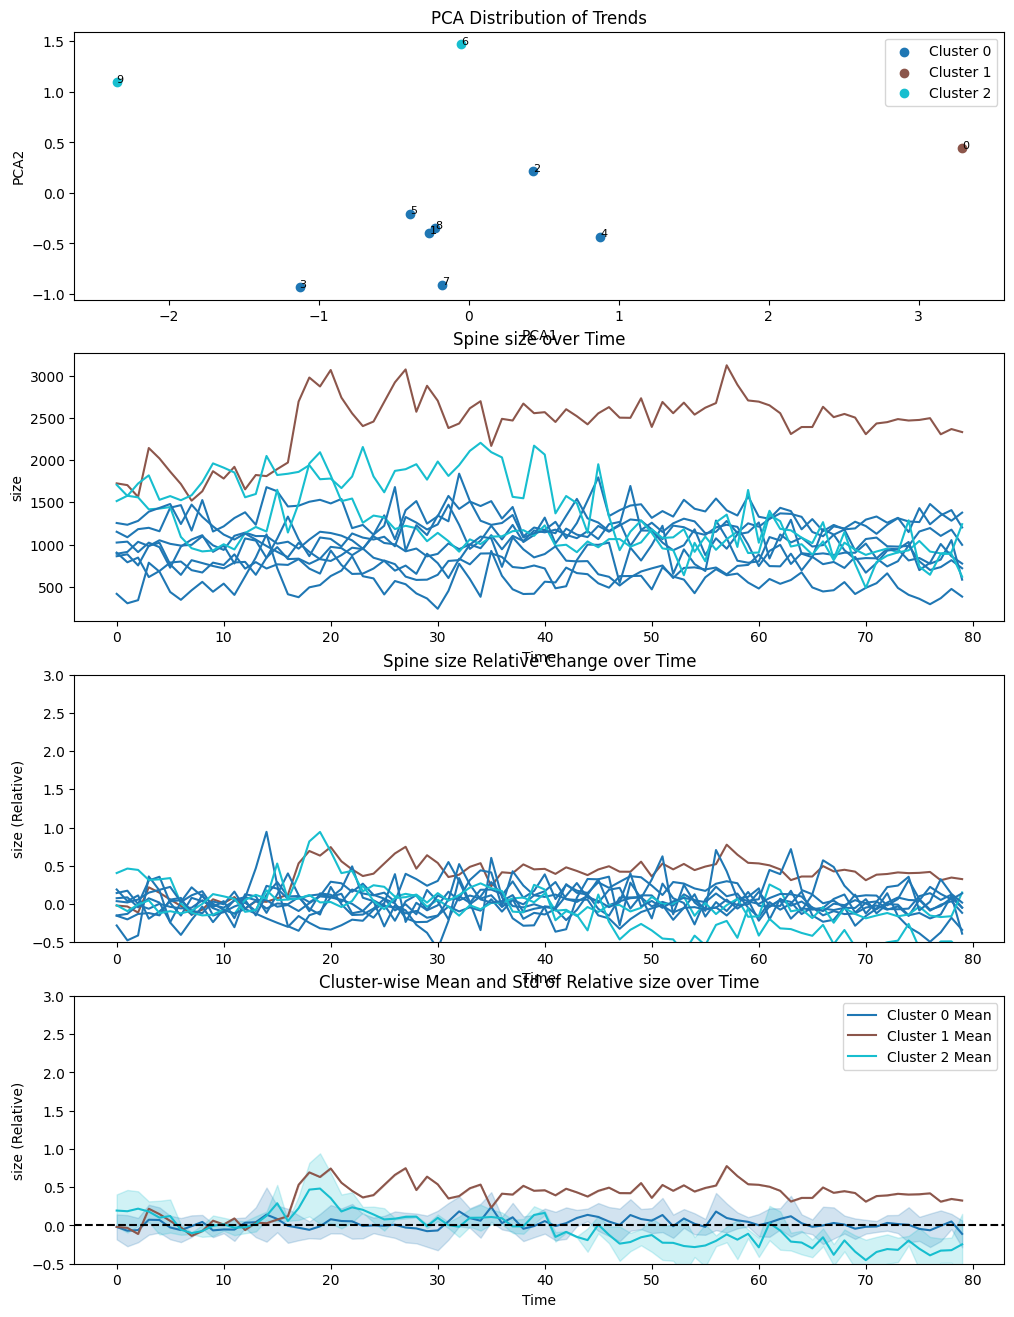

In [142]:
pca_trend, kmeans_trend, good_spine_ids = pca_kmeans_time_series(roi3_dir_path,roi3_spine_infos_merged,roi3_ID_or_index_2_patch_ID_dict, 'size')

spine_infos_index: 0
spine_infos_index: 1
spine_infos_index: 2
spine_infos_index: 3
Good spine nums: 4


/share/home/lizhuo/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_1462832/3280282714.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', cluster_num)


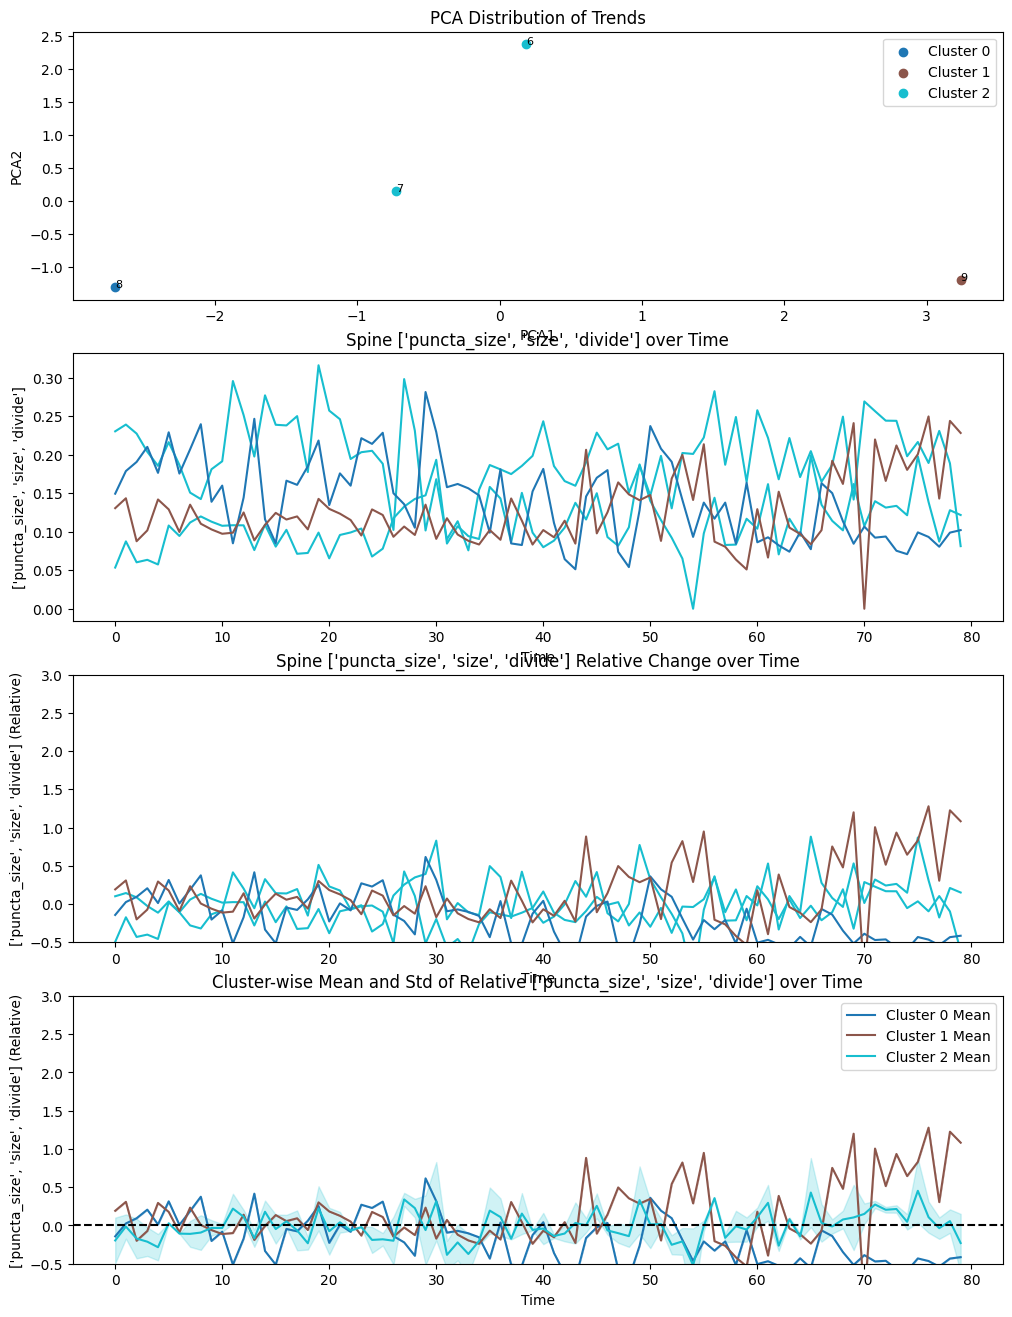

In [119]:
pca_trend, kmeans_trend, good_spine_ids = pca_kmeans_time_series(root,spine_infos,ID2spines_infos_list_index_dict, ['puncta_size','size','divide'],exclude_list=[4])

In [14]:
roi1_ID_or_index_2_patch_ID_dict[4]


'0008_5'

spine_infos_index: 4  ---  0008_5
spine_infos_index: 5  ---  0008_6
spine_infos_index: 6  ---  0018_1
spine_infos_index: 7  ---  0018_2
spine_infos_index: 8  ---  0018_3
spine_infos_index: 10  ---  0018_5
spine_infos_index: 11  ---  0010_1
spine_infos_index: 12  ---  0010_2
spine_infos_index: 13  ---  0010_3
Good spine nums: 9


/share/home/lizhuo/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_1977596/1863997788.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', cluster_num)


570.6
2024.9
1010.5
384.3
1020.5
1070.3
1721.0
1420.0
352.8


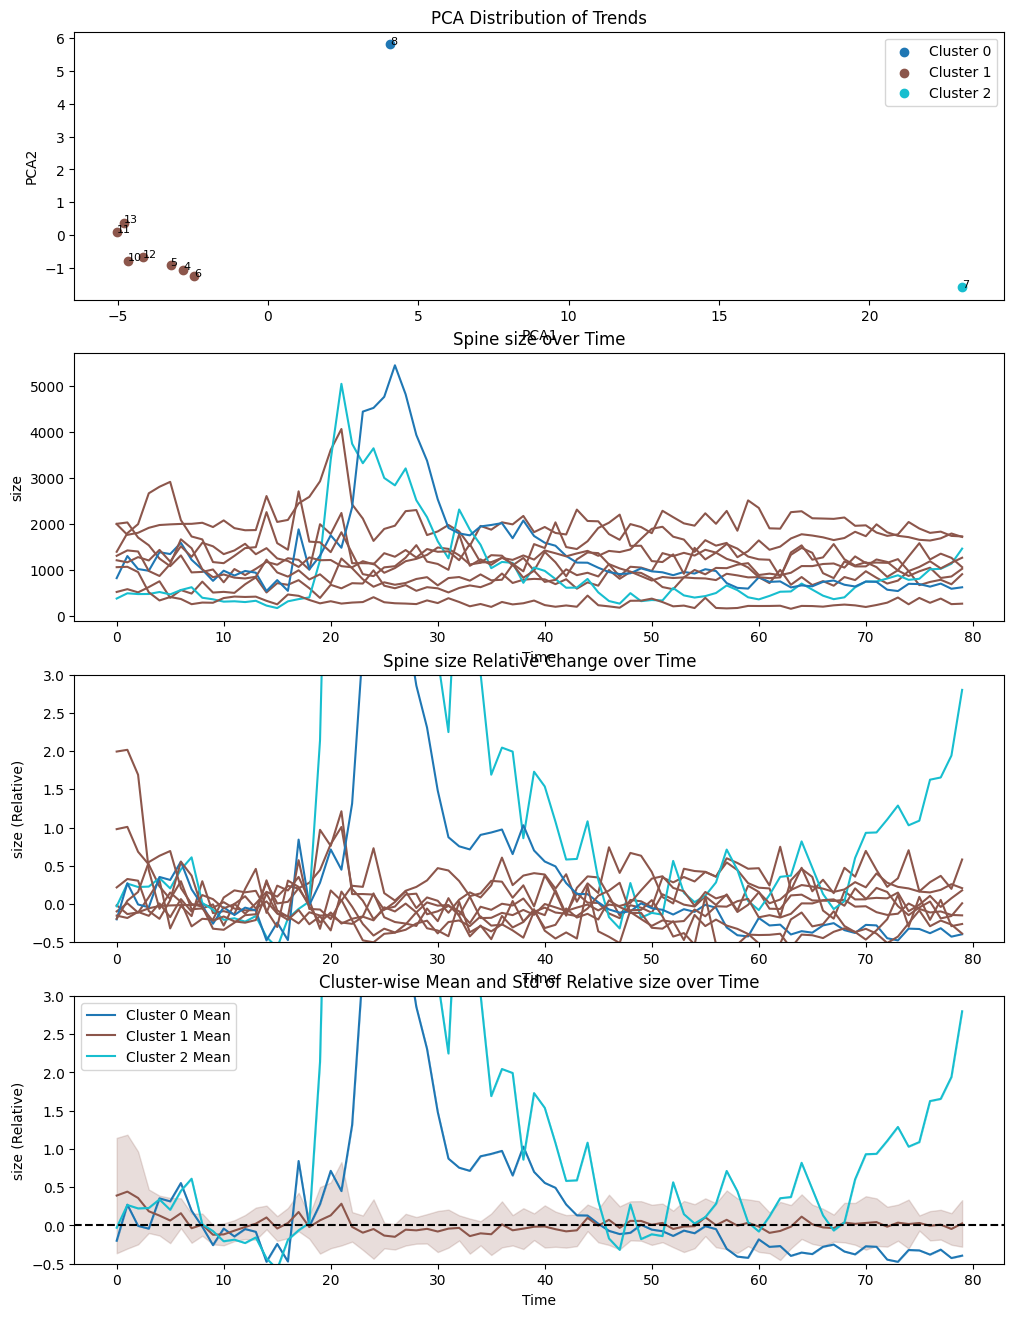

In [13]:
pca_trend, kmeans_trend, good_spine_ids = pca_kmeans_time_series(roi1_dir_path,roi1_spine_infos_merged,roi1_ID_or_index_2_patch_ID_dict, 'size',exclude_list=[3])

In [141]:
roi1_spine_infos_merged[7]['t']
#roi1_ID_or_index_2_patch_ID_dict[1]

[16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79]

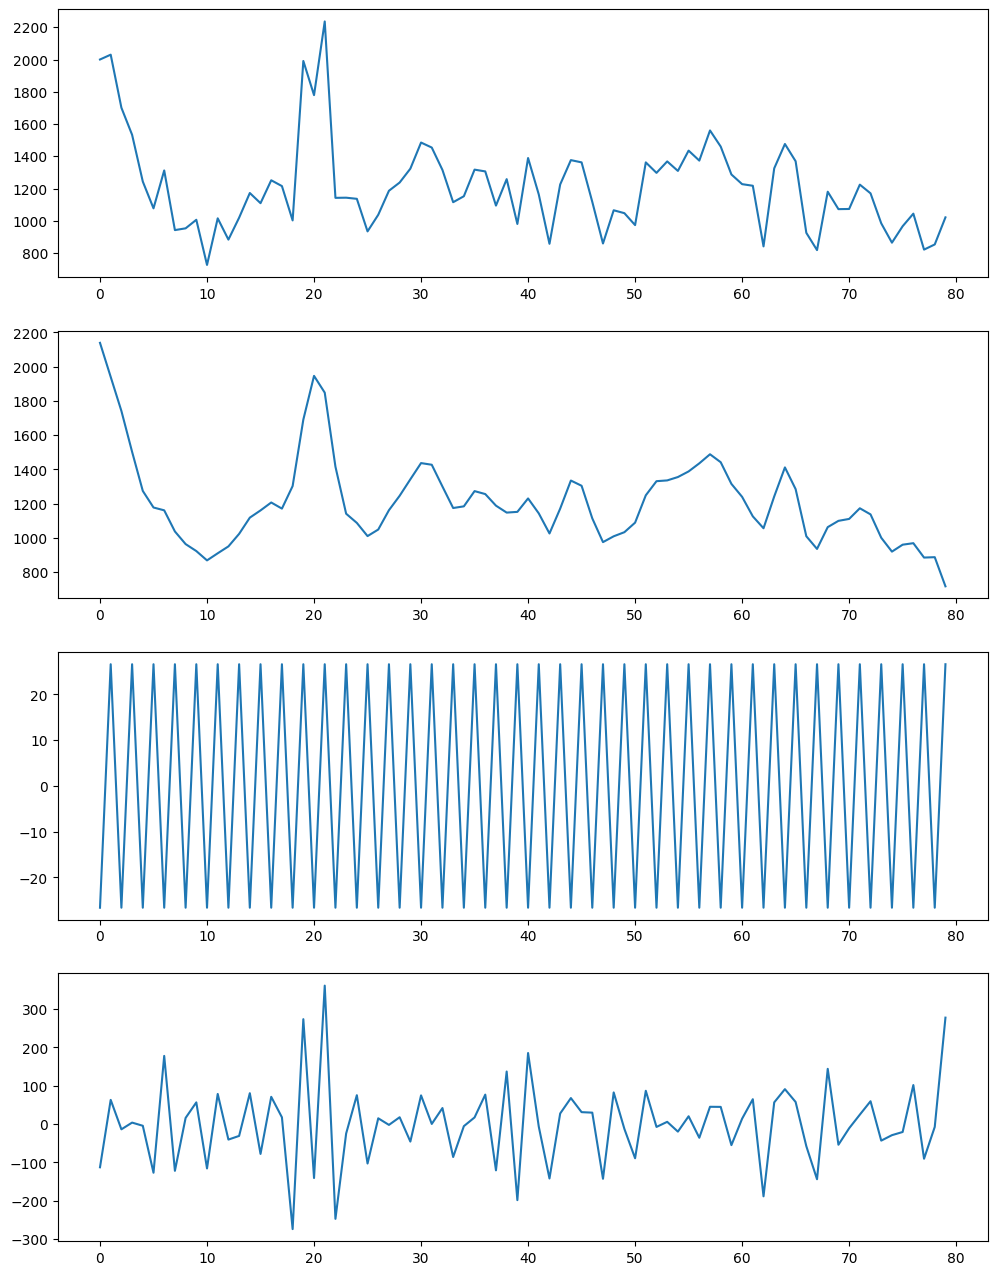

In [100]:
data = roi1_spine_infos_merged[3]['size']
decomposition = seasonal_decompose(data, period=2, model='additive', extrapolate_trend='freq')

fig_all, ax_all = plt.subplots(4, 1, figsize=(12,16))
ax_all[0].plot(data)
ax_all[1].plot(decomposition.trend)
ax_all[2].plot(decomposition.seasonal)
ax_all[3].plot(decomposition.resid)
plt.show()

In [98]:
def check_seasonality(data, period=[1,2,5,10,20]):
    series_r2 = []
    for p in period:
        decomposition = seasonal_decompose(data, period=p, model='additive', extrapolate_trend='freq')
        trend = decomposition.trend[~np.isnan(decomposition.trend)]
        r2 = np.var(trend) / np.var(data)
        series_r2.append(r2)
        print(f'Period {p} R2: {r2}')



check_seasonality(data, period=[1,2,5,10,20])

Period 1 R2: 1.0
Period 2 R2: 0.7875277262199628
Period 5 R2: 0.5636694925201893
Period 10 R2: 0.18080520029548203
Period 20 R2: 0.036842552101669056
